In [101]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [102]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

In [103]:
orig_data = pd.read_csv('column_2C.dat', sep=" ", header=None, names=["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "grade_spondylolisthesis", "abnormal"])
orig_data.replace('AB', 1, inplace=True)
orig_data.replace('NO', 0, inplace=True)
orig_data.head(5)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_spondylolisthesis,abnormal
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


Data is described [here](http://archive.ics.uci.edu/ml/datasets/vertebral+column)

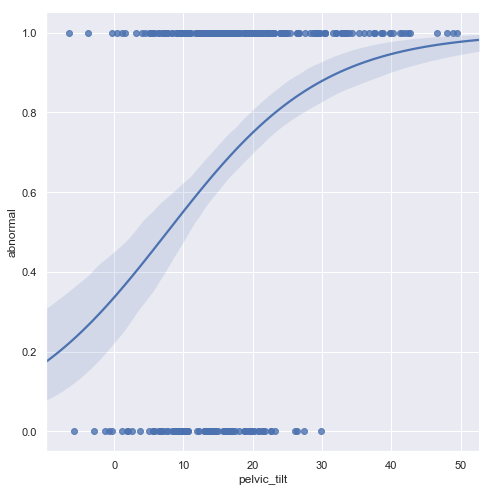

In [104]:
sns.set(color_codes=True)
filtered_df = orig_data
sns.lmplot(x="pelvic_tilt", y="abnormal", height=7, logistic=True, n_boot=250, data=filtered_df);

In [105]:
def _find_min_max(seq):
    min_x, max_x = seq.min(), seq.max()
    diff_x = max_x - min_x
    min_x, max_x = min_x - 0.1 * diff_x, max_x + 0.1 * diff_x
    return min_x, max_x
    
def logistic_2d_plot(x_labels, y_label, df):
    model = LogisticRegression()
    model.fit(df[x_labels].values, df[y_label].values)    
    slope = -1 * model.coef_[0][0] / model.coef_[0][1]
    intercept = -1 * model.intercept_ / model.coef_[0][1]
    min_x1, max_x1 = _find_min_max(df[x_labels[0]])
    min_x2, max_x2 = _find_min_max(df[x_labels[1]])
    
    x1_range = np.linspace(min_x1, max_x1, 3)
    x2_range = x1_range*slope + intercept
    grid = sns.relplot(x=x_labels[0], y=x_labels[1], height=7, hue=y_label, style=y_label, data=filtered_df);
    plt.plot(x1_range, x2_range, linewidth=2, color="g")
    plt.ylim(min_x2, max_x2)

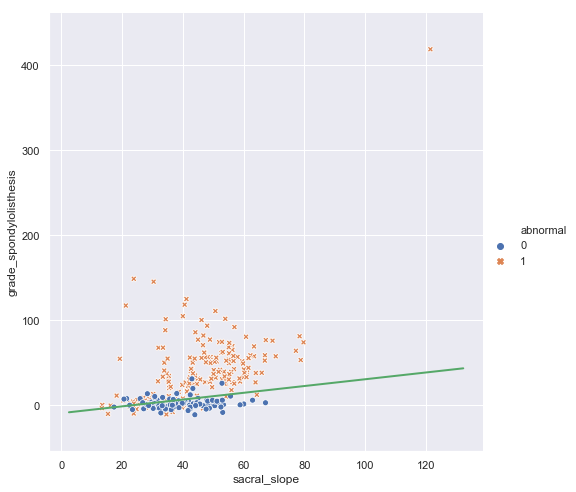

In [153]:
logistic_2d_plot(["sacral_slope", "grade_spondylolisthesis"], "abnormal", filtered_df)

In [194]:
def get_all_X_columns(df):
    return df[["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "grade_spondylolisthesis"]]

def get_X_columns(df):
    return df[["grade_spondylolisthesis", "pelvic_tilt", "sacral_slope"]]

def get_X_null_columns(df):
    return df[["grade_spondylolisthesis", "lumbar_lordosis_angle", "pelvic_radius"]]

def get_Y_column(df):
    return df["abnormal"]

In [195]:
def get_XY(data, X_columns_func=get_all_X_columns):
    X = X_columns_func(data).values
    Y = get_Y_column(data).values
    return X, Y

In [23]:
def get_model(X_train, Y_train):
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    return model

In [83]:
def get_errors(Y_train, Y_train_prob, Y_test, Y_test_prob):
    return roc_auc_score(Y_train, Y_train_prob), roc_auc_score(Y_test, Y_test_prob)    

In [25]:
def plot_histogram(X, Y):
    print(list(zip(X, Y)))
    plt.bar(X, Y)
    for a,b in zip(X, Y):
        plt.text(a, b, "{0:.2f}".format(b))

    plt.show()
    
def plot_feature_weights(data, intercept, coef, X_columns_func=get_all_X_columns):
    features = np.append(X_columns_func(data).columns.values, "intercept")
    weights = np.append(coef, intercept)
    plot_histogram(features, weights)

[('pelvic_incidence', 0.023282952673792916), ('pelvic_tilt', 0.08932863599558073), ('lumbar_lordosis_angle', -0.028877816400463215), ('sacral_slope', -0.05479355624553811), ('pelvic_radius', -0.01780519957152075), ('grade_spondylolisthesis', 0.1531749532452599), ('intercept', 1.9652251470238942)]


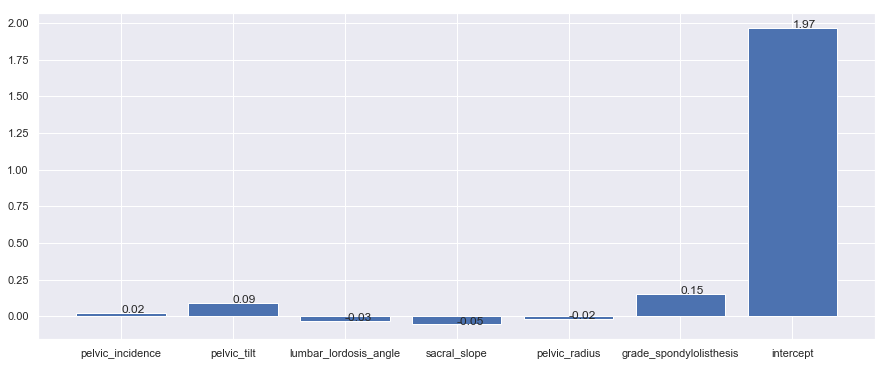

In [175]:
## Fitting attempt 1
X_train, Y_train = get_XY(orig_data)
model = get_model(X_train, Y_train)
plot_feature_weights(orig_data, model.intercept_, model.coef_)

In [203]:
def lr_test_pair(X_train_p0, X_train_p1, Y_train):
    model_p1 = get_model(X_train_p1, Y_train)
    Y_pred_p1 = model_p1.predict_proba(X_train_p1)
    log_likelihood_p1 = -log_loss(Y_train, Y_pred_p1)

    model_p0 = get_model(X_train_p0, Y_train)
    Y_pred_p0 = model_p0.predict_proba(X_train_p0)
    log_likelihood_p0 = -log_loss(Y_train, Y_pred_p0)
    
    chisq_score = 2 * (log_likelihood_p1 - log_likelihood_p0)
    p_value = 1 - stats.chi2.cdf(chisq_score, 1)
    
    return chisq_score, p_value

def lr_test(X_train, Y_train):
    chisq_scores = []
    p_values = []
    num_columns = X_train.shape[1]
    
    model_p1 = get_model(X_train, Y_train)
    Y_pred_p1 = model_p1.predict_proba(X_train)
    log_likelihood_p1 = -log_loss(Y_train, Y_pred_p1)
    
    for col_id in range(0, num_columns):
        X_train_p0 = np.delete(X_train, col_id, axis=1)
        model_p0 = get_model(X_train_p0, Y_train)
        Y_pred_p0 = model_p0.predict_proba(X_train_p0)
        log_likelihood_p0 = -log_loss(Y_train, Y_pred_p0)

        chisq_score = 2 * (log_likelihood_p1 - log_likelihood_p0)
        p_value = 1 - stats.chi2.cdf(chisq_score, 1)
        chisq_scores.append(chisq_score)
        p_values.append(p_value)
        
    return np.nan_to_num(chisq_scores, 0), np.nan_to_num(p_values, 0)

[('pelvic_incidence', -2.3030287072955957e-06), ('pelvic_tilt', 6.705991359767793e-06), ('lumbar_lordosis_angle', 0.00536403644830874), ('sacral_slope', 2.1886217046462875e-06), ('pelvic_radius', 0.027515128158083657), ('grade_spondylolisthesis', 0.3601517710283647)]


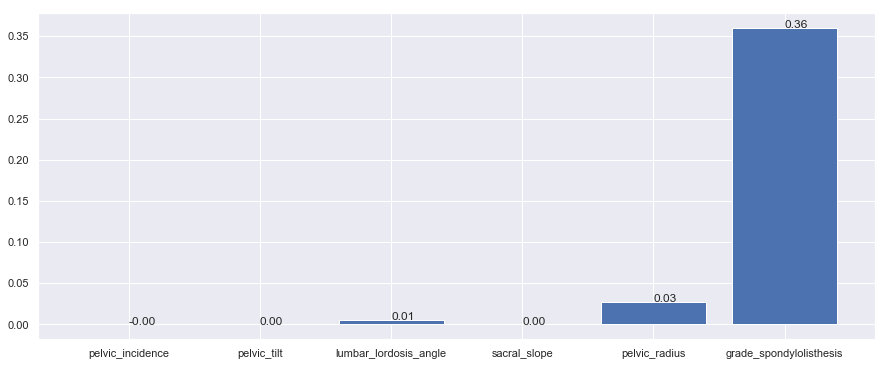

[('pelvic_incidence', 1.0), ('pelvic_tilt', 0.9979338061199464), ('lumbar_lordosis_angle', 0.941615468649857), ('sacral_slope', 0.9988196107273751), ('pelvic_radius', 0.8682538689760964), ('grade_spondylolisthesis', 0.548421957845348)]


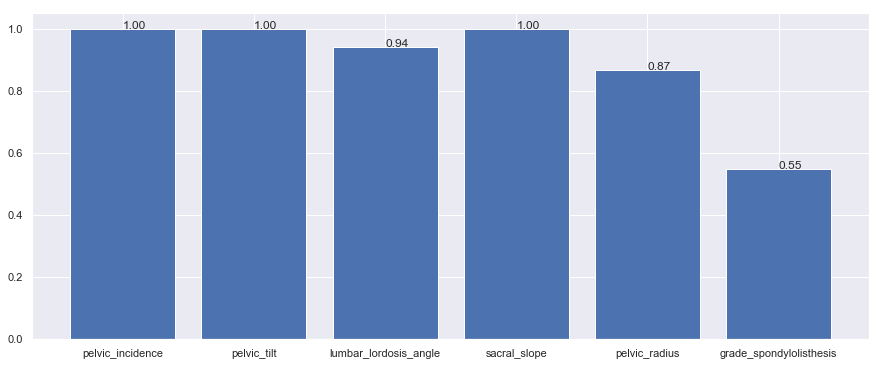

In [188]:
columns = get_all_X_columns(orig_data).columns
ch, p = lr_test(X_train, Y_train)

plot_histogram(columns, ch)
plot_histogram(columns, p)

In [204]:
lr_test_pair(get_X_columns(orig_data), get_X_null_columns(orig_data), get_Y_column(orig_data))

(-0.037167227736099595, 1.0)

In [201]:
def cross_validate_error(model_builder):
    sum_train_error = 0
    sum_test_error = 0
    
    sum_train_acc = 0
    sum_test_acc = 0

    splits = 5
    kf = KFold(n_splits=splits, shuffle=True)
    for train_indices, test_indices in kf.split(orig_data):
        data_train = orig_data.iloc[train_indices]
        data_test = orig_data.iloc[test_indices]
        #print ("Training, test data shape:", data_train.shape, data_test.shape)
    
        X_data_train, Y_data_train = get_XY(data_train, get_X_columns)
        model = model_builder(X_data_train, Y_data_train)
        #plot_feature_weights(model.coef_, get_X_columns)
    
        X_train, Y_train = get_XY(data_train, get_X_columns)
        X_test, Y_test = get_XY(data_test, get_X_columns)
        Y_train_pred, Y_test_pred = model.predict_proba(X_train)[:,1], model.predict_proba(X_test)[:,1]
                
        training_auc, test_auc = get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred)
        
        sum_train_error += training_auc
        sum_test_error += test_auc

        train_acc, test_acc = model.score(X_train, Y_train), model.score(X_test, Y_test)
    
        sum_train_acc += train_acc
        sum_test_acc += test_acc

    return sum_train_acc/splits, sum_test_acc/splits, sum_train_error/splits, sum_test_error/splits

In [202]:
cross_validate_error(get_model)

(0.8532258064516128,
 0.8419354838709678,
 0.9130656892947225,
 0.9100135575795656)